# Handwriting digits recogniton with CNN:




## pre-process

In [0]:
# necessary setting:
%matplotlib inline
# import library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau



Using TensorFlow backend.


## HOW TO LOAD DATA FROM GOOGLE DRIVER TO COLAB:
- MOUNT TO /content/gdrive
- PS: can only access under MY Driver 


In [0]:
# LOAD DATA FROM GOOOGLE DRIVER

from google.colab import drive

drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Load DATA :

In [0]:
train = pd.read_csv("gdrive/My Drive/train.csv")


In [0]:
test=pd.read_csv("gdrive/My Drive/test.csv")

## DATA process:
- data and labels
- normalize/ transforms ...

In [0]:
# split data to dataset and labels:
y_train=train["label"]
x_train=train.drop(labels = ["label"],axis = 1) 
del train

[pandas_drop](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop.html)



In [0]:
# normalize data:
x_train=x_train/255.0
test=test/255.0

In [0]:
# reshape data:
x_train=x_train.values.reshape(-1,28,28,1)
test=test.values.reshape(-1,28,28,1)

([<matplotlib.axis.XTick at 0x7fc8d6efa668>,
 <a list of 11 Text xticklabel objects>)

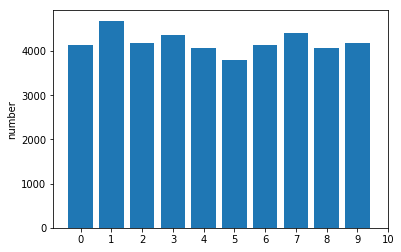

In [0]:
m=y_train.value_counts()
y=[]
for i in range(len(m)):
  y.append(m[i])
plt.bar(range(0,10),y)
plt.ylabel("number")
plt.xticks(range(0,11))

## one_hot_encoding:
### from numerical value to vector 

In [0]:
y_train=to_categorical(y_train, num_classes = 10)


## split the datasets to trainng and validations:
### ps things to note:
- percentage
- random
- ! for some unbalanced dataset random split will need to inaccuracy

In [0]:
# check if the data is balanced:
# refer to the former line: before one hot encoding 

In [0]:
# split the datasets to train and validation sets:
x_train,x_val,y_train,y_val=train_test_split(x_train,y_train,test_size=0.1,random_state=2)

## CNN STRUCTURE:

In [0]:
model=Sequential()
model.add(Conv2D(filters=32,kernel_size=(5,5),padding="Same",activation="relu",input_shape=(28,28,1)))
model.add(Conv2D(filters=32,kernel_size=(5,5),padding="Same",activation="relu"))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))
          

### compile cnn structure:
[optimizer](https://towardsdatascience.com/understanding-rmsprop-faster-neural-network-learning-62e116fcf29a)

In [0]:
optimizer=RMSprop(lr=0.001,rho=0.9,epsilon=1e-08, decay=0.0)

In [0]:
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

### learning rate problem:
  ### AIM:
  
  -Convergence fast
  -Accuracy
  
  decrease lr if accuracy not improve

In [0]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
# if the val_acc not improve for 3 epoches half the lr if it bigger than min_lr

### Data augmentation:
- in order to avoid overfitting : data augmentation to get more data:


In [0]:
# With data augmentation to prevent overfitting (accuracy 0.99286)

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)


datagen.fit(x_train)

## train CNN:
- without data augmentation
- with data augmentation

In [0]:
# setting:
epochs = 3 # Turn epochs to 30 to get 0.9967 accuracy
batch_size = 86


In [0]:
## train 

# without :
# Without data augmentation i obtained an accuracy of 0.98114
history = model.fit(x_train, y_train, batch_size = batch_size, epochs = epochs, 
         validation_data = (x_val, y_val), verbose = 2)


Train on 37800 samples, validate on 4200 samples
Epoch 1/1
 - 8s - loss: 0.2566 - acc: 0.9176 - val_loss: 0.0578 - val_acc: 0.9788


In [0]:
 history = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_val,y_val),
                              verbose = 2, steps_per_epoch=x_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])


Epoch 1/3
 - 15s - loss: 0.0824 - acc: 0.9760 - val_loss: 0.0345 - val_acc: 0.9879
Epoch 2/3
 - 14s - loss: 0.0726 - acc: 0.9782 - val_loss: 0.0271 - val_acc: 0.9905
Epoch 3/3
 - 14s - loss: 0.0684 - acc: 0.9803 - val_loss: 0.0246 - val_acc: 0.9914


## Evaluate NN :
- learning curves
- confusion matrix
- see the misclasify example

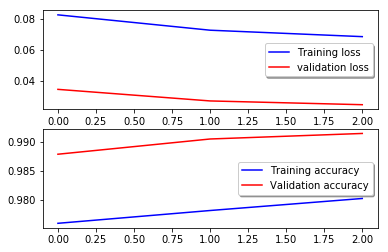

In [0]:
# learning curves: for many epoches;
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

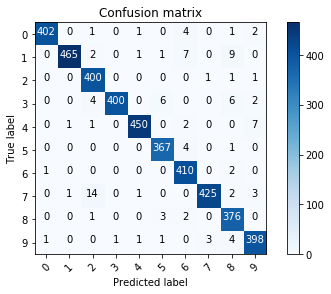

In [0]:
# confusion matrix:
import itertools
cm = confusion_matrix(true, predictions) 
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
plot_confusion_matrix(cm, classes = range(10)) 


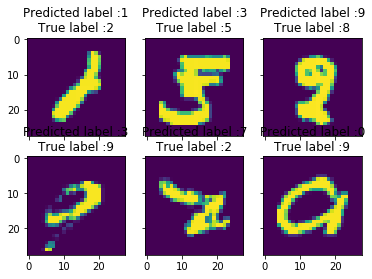

In [0]:
# see misclassify example:
# Display some error results 

# Errors are difference between predicted labels and true labels
errors = (predictions - true!= 0)

Y_pred_classes_errors = predictions[errors]
Y_pred_errors = vectors[errors]
Y_true_errors = true[errors]
X_val_errors = x_val[errors]

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1

# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors 
most_important_errors = sorted_dela_errors[-6:]

# Show the top 6 errors
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)

### use in new example:


In [0]:
vectors=model.predict(x_val)
predictions=np.argmax(vectors,axis=1)
true=np.argmax(y_val,axis=1)
predictions[0] ,true[0]

(3, 3)

### UPLOAD FILE TO GOOGLE DRIVER:
gdrive/My Drive/

In [0]:
# predict test set:
# predict results
results = model.predict(test)

# select the indix with the maximum probability
results = np.argmax(results,axis = 1)

# from data to csv file:
results = pd.Series(results,name="Label")
id=pd.Series(range(1,28001),name = "ImageId")
submission=pd.concat([id,results],axis=1)

submission.to_csv("gdrive/My Drive/cnn_mnist_datagen.csv",index=False)

## Summary:
### pre-process:
- google data get 

### data process:
- load
- normalize
- reshape
- nil
- balance
- split

### construct nn :
- model
- optmiizer
- compile

### evaluation:
- curves
- data
- confusion matrix
- error present 

### test:
- predict